In [20]:
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms import community

In [25]:
G = nx.read_weighted_edgelist("./tiny_edge_list.csv", delimiter=",")

In [26]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 179
Number of edges: 228
Average degree:   2.5475


In [42]:
# nx.get_node_attributes(G, "size")

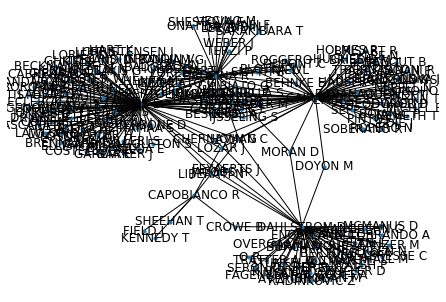

In [48]:
nx.draw(G, node_size = 10, with_labels=True, font_size = 12)

In [31]:
communities_generator = community.girvan_newman(G)

In [32]:
top_level_communities = next(communities_generator)

In [ ]:
# TODO: Get all the stats we had from gephi

In [36]:
# Order them somehow?
len(top_level_communities)

2

In [33]:
next_level_communities = next(communities_generator)

In [1]:
# sorted(map(sorted, next_level_communities))